# set up the datasets

In [20]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# hide future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a DataFrame to store file paths and labels
df = pd.DataFrame(columns=['image', 'label'])

# Read images from the directory and assign labels based on file prefixes
for filename in os.listdir('../data/competition_data/glioma_tumor'):
    label = 'glioma_tumor'
    df = df.append({'image': filename, 'label': label}, ignore_index=True)
    
# Read images from the directory and assign labels based on file prefixes
for filename in os.listdir('../data/competition_data/meningioma_tumor'):
    label = 'meningioma_tumor'
    df = df.append({'image': filename, 'label': label}, ignore_index=True)
    
# Read images from the directory and assign labels based on file prefixes
for filename in os.listdir('../data/competition_data/pituitary_tumor'):
    label = 'pituitary_tumor'
    df = df.append({'image': filename, 'label': label}, ignore_index=True)

# Read images from the directory and assign labels based on file prefixes
for filename in os.listdir('../data/competition_data/normal'):
    label = 'normal'
    df = df.append({'image': filename, 'label': label}, ignore_index=True)

# Shuffle the DataFrame
df = shuffle(df)

# Split the data into training and validation sets
df_train, df_non_train = train_test_split(df, test_size=0.2, random_state=42)
df_validation, df_test = train_test_split(df_non_train, test_size=0.5, random_state=42)

# Convert labels to numeric 
label2id = {'normal': 0, 'glioma_tumor': 1,
            'meningioma_tumor': 2, 'pituitary_tumor': 3}
id2label = {0: 'normal', 1: 'glioma_tumor',
            2: 'meningioma_tumor', 3: 'pituitary_tumor'}
df_train['label'] = df_train['label'].map(label2id)
df_validation['label'] = df_validation['label'].map(label2id)
df_test['label'] = df_test['label'].map(label2id)

# Display the shape and first 20 rows of the training DataFrame
df_train.shape, df_test.shape, df_validation.shape

((1980, 2), (248, 2), (247, 2))

In [15]:
# log where image name is M_219.jpg
df_train[df_train['image'] == 'M_219.jpg']

,image,label
138,M_219.jpg,2


In [16]:
# !pip install transformers
# !pip install matplotlib

# define the transformer dataset and the model classes

In [21]:
import torch
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm import tqdm
from PIL import Image  # Importing the Image class
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BrainTumorDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.resize = transforms.Resize((224, 224))
        self.ToTensor = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        base_path = "../data/competition_data/"
        label = self.df.iloc[idx, 1]
        if label == 1:
            base_path += "glioma_tumor/"
        if (label == 0):
            base_path += "normal/"
        if (label == 2):
            base_path += "meningioma_tumor/"
        if (label == 3):
            base_path += "pituitary_tumor/"
        filename = self.df.iloc[idx, 0]
        full_img_path = os.path.join(base_path, filename)
        raw_image = Image.open(full_img_path)
        image = self.resize(raw_image)
        image = self.ToTensor(image)
        
        return image, label

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(
            'google/vit-base-patch16-224-in21k', add_pooling_layer=False)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        x = self.classifier(x[:, 0, :])
        return x

# train the model on the train dataset and use the validation dataset to calculate loss

In [ ]:

# Initialize dataset and dataloader
train_dataset = BrainTumorDataset(df_train)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

validation_dataset = BrainTumorDataset(df_validation)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

def evaluate_model(model, validation_dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = val_loss / len(validation_dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


# Initialize model
model = ViTForImageClassification(num_labels=len(label2id))
model = model.to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters())

for epoch in range(500):  # Maximum number of epochs
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_dataloader):
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    validation_loss, validation_accuracy = evaluate_model(model, validation_dataloader, criterion, device)
    print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_dataloader)}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

    # Save the model
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

    # Ask if continue training
    if validation_accuracy > 0.95:
        break

# run the model on the test dataset

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 248/248 [00:20<00:00, 11.82it/s]


Accuracy: 0.9798387096774194


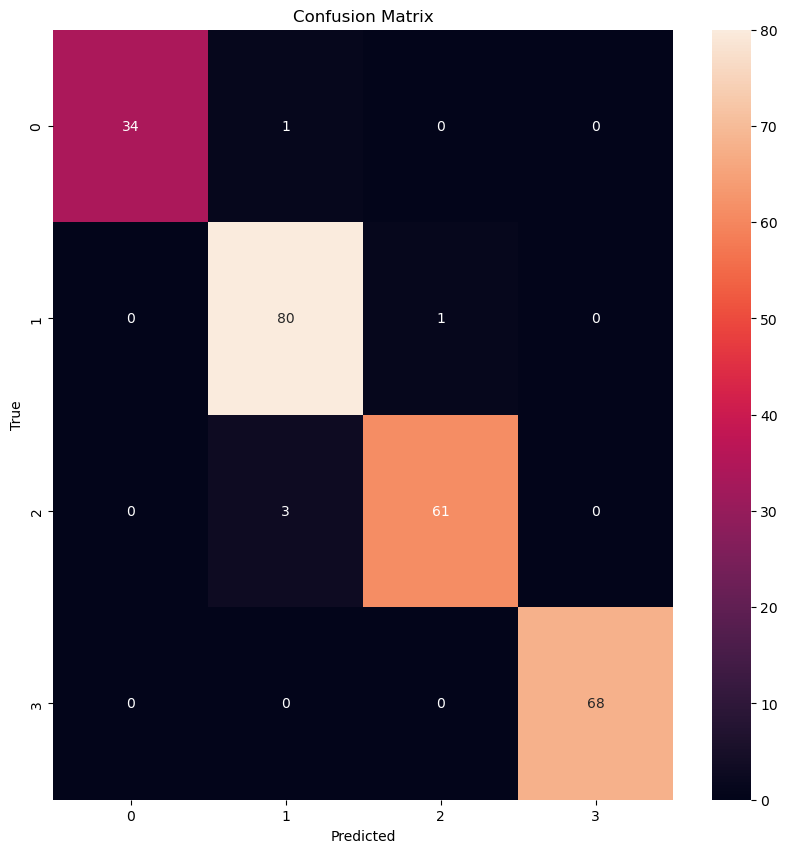

In [24]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# load the model
model = ViTForImageClassification(num_labels=len(label2id))
model.load_state_dict(torch.load('model_epoch_58.pth', map_location=torch.device('cpu') if not torch.cuda.is_available() else None))
model = model.to(device)

# use the trained model to predict on the validation set
model.eval()
dataset = BrainTumorDataset(df_test)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()
print(f"Accuracy: {correct / total}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# run the model on the kaggle dataset and get the labels for submission

In [12]:
print(torch.cuda.is_available())
df = pd.DataFrame(columns=['image', 'label'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

possible_labels = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'normal']

# Read images from the directory and assign labels based on file prefixes
# if the TA is going to run this then please change the path to the kaggle_solutionSet in the first cell and and also in the dataloader
# it will not work if the path is not changed
for filename in os.listdir('./data/kaggle_solutionSet'):
    label = 'unknown'
    df = df.append({'image': filename, 'label': label}, ignore_index=True)

label2id = {'normal': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}
id2label = {0: 'normal', 1: 'glioma_tumor', 2: 'meningioma_tumor', 3: 'pituitary_tumor'}

model = ViTForImageClassification(num_labels=len(label2id))
model.load_state_dict(torch.load('model_epoch_58.pth'))
model = model.to(device)
model.eval()

# Data loader
result_dataset = BrainTumorDataset(df)
result_dataloader = DataLoader(result_dataset, batch_size=1, shuffle=False)

df_result = pd.DataFrame(columns=['ID', 'prediction'])

# Predict and save labels
for i, (images, _) in enumerate(tqdm(result_dataloader)):
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    label_id = predicted.item()
    label_name = id2label[label_id]
    df_result.at[i, 'prediction'] = label_name
    df_result.at[i, 'ID'] = df.iloc[i, 0]

# Save DataFrame to CSV
df_result.to_csv('predicted_labels.csv', index=False)

True


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 621/621 [00:06<00:00, 98.77it/s]
